# Interaction Effects for Pitcher Injury Risk

This notebook explores interaction terms that capture combined effects:
- **Age × Workload**: Older pitchers more vulnerable to high workloads
- **Age × Performance**: Age + declining performance = higher risk
- **Workload × Performance**: High workload + poor performance = fatigue/breakdown
- **Veteran × Usage**: Veteran status interactions with usage patterns

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.utils import concordance_index
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Load Data and Explore Potential Interactions

In [2]:
# Load the enhanced dataset
df = pd.read_csv('../data/processed/survival_dataset_lagged_enhanced.csv')

print(f"Dataset: {df.shape}")
print(f"Event rate: {df['event'].mean():.1%}")

# Key variables for interactions
age = df['age_prev']
workload_vars = ['ip_prev', 'g_prev', 'gs_prev']
performance_vars = ['era_prev', 'whip_prev', 'war_prev']
usage_vars = ['high_workload_prev', 'veteran_prev', 'high_era_prev']

print(f"\nKey interaction variables:")
print(f"Age range: {age.min():.1f} - {age.max():.1f}")
print(f"Workload vars: {workload_vars}")
print(f"Performance vars: {performance_vars}")
print(f"Usage vars: {usage_vars}")

Dataset: (1284, 50)
Event rate: 40.7%

Key interaction variables:
Age range: 21.0 - 42.0
Workload vars: ['ip_prev', 'g_prev', 'gs_prev']
Performance vars: ['era_prev', 'whip_prev', 'war_prev']
Usage vars: ['high_workload_prev', 'veteran_prev', 'high_era_prev']


## 2. Visualize Potential Interaction Patterns

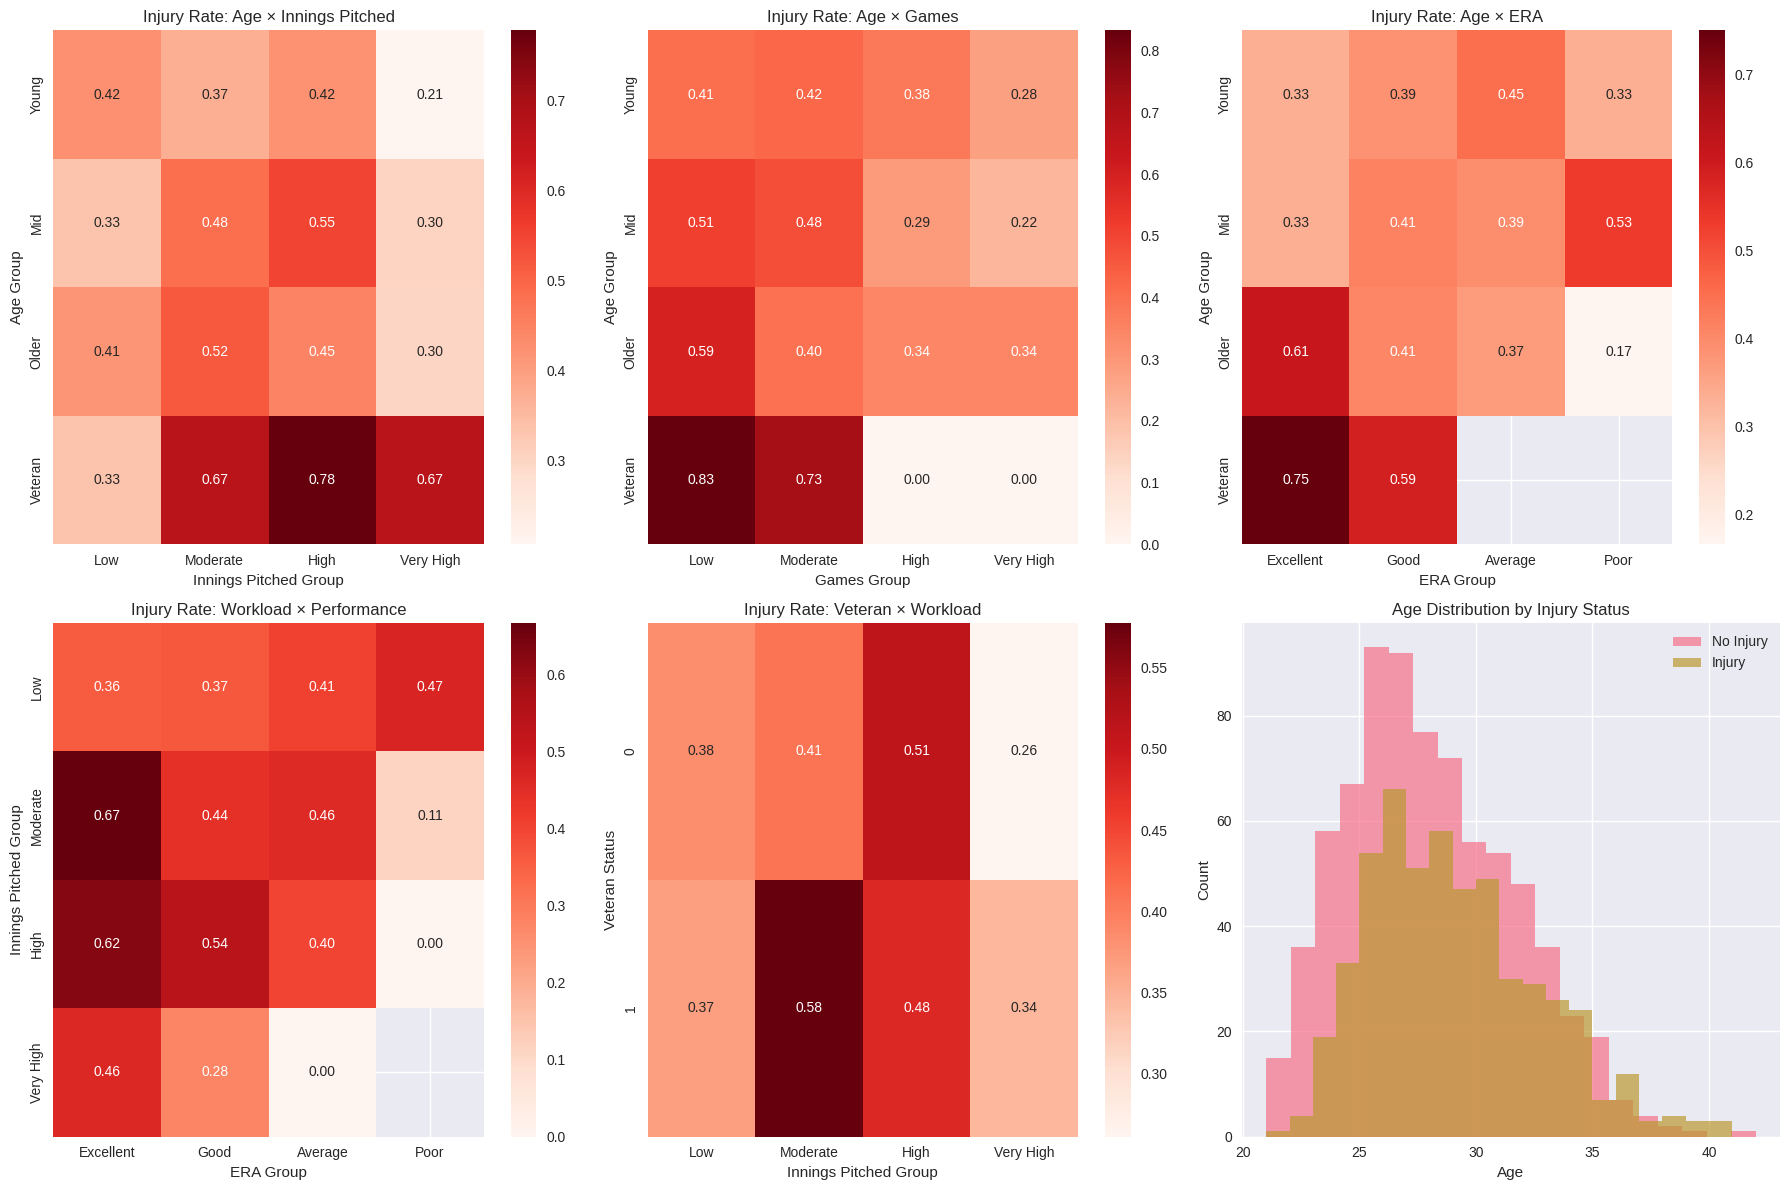


🎯 INTERACTION PATTERN ANALYSIS:
Interaction strength (higher variance = stronger interaction):
  Age × Games              : 0.0459
  Age × Innings Pitched    : 0.0223
  Age × ERA                : nan
  Workload × Performance   : nan
  Veteran × Workload       : 0.0090

Most promising for modeling: Age × Games


In [3]:
# Explore age × workload interactions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Age × Innings Pitched interaction
df['age_group'] = pd.cut(df['age_prev'], bins=4, labels=['Young', 'Mid', 'Older', 'Veteran'])
df['ip_group'] = pd.cut(df['ip_prev'], bins=4, labels=['Low', 'Moderate', 'High', 'Very High'])

# Injury rate by age and workload
interaction_df = df.groupby(['age_group', 'ip_group'])['event'].agg(['count', 'sum', 'mean']).reset_index()
interaction_df['injury_rate'] = interaction_df['mean']

# Pivot for heatmap
heatmap_data = interaction_df.pivot(index='age_group', columns='ip_group', values='injury_rate')
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='Reds', ax=axes[0,0])
axes[0,0].set_title('Injury Rate: Age × Innings Pitched')
axes[0,0].set_xlabel('Innings Pitched Group')
axes[0,0].set_ylabel('Age Group')

# 2. Age × Games interaction
df['g_group'] = pd.cut(df['g_prev'], bins=4, labels=['Low', 'Moderate', 'High', 'Very High'])
games_interaction = df.groupby(['age_group', 'g_group'])['event'].mean().unstack()
sns.heatmap(games_interaction, annot=True, fmt='.2f', cmap='Reds', ax=axes[0,1])
axes[0,1].set_title('Injury Rate: Age × Games')
axes[0,1].set_xlabel('Games Group')
axes[0,1].set_ylabel('Age Group')

# 3. Age × ERA interaction
df['era_group'] = pd.cut(df['era_prev'], bins=4, labels=['Excellent', 'Good', 'Average', 'Poor'])
era_interaction = df.groupby(['age_group', 'era_group'])['event'].mean().unstack()
sns.heatmap(era_interaction, annot=True, fmt='.2f', cmap='Reds', ax=axes[0,2])
axes[0,2].set_title('Injury Rate: Age × ERA')
axes[0,2].set_xlabel('ERA Group')
axes[0,2].set_ylabel('Age Group')

# 4. Workload × Performance interaction (IP × ERA)
workload_perf = df.groupby(['ip_group', 'era_group'])['event'].mean().unstack()
sns.heatmap(workload_perf, annot=True, fmt='.2f', cmap='Reds', ax=axes[1,0])
axes[1,0].set_title('Injury Rate: Workload × Performance')
axes[1,0].set_xlabel('ERA Group')
axes[1,0].set_ylabel('Innings Pitched Group')

# 5. Veteran status × Workload
veteran_workload = df.groupby(['veteran_prev', 'ip_group'])['event'].mean().unstack()
sns.heatmap(veteran_workload, annot=True, fmt='.2f', cmap='Reds', ax=axes[1,1])
axes[1,1].set_title('Injury Rate: Veteran × Workload')
axes[1,1].set_xlabel('Innings Pitched Group')
axes[1,1].set_ylabel('Veteran Status')

# 6. Age distribution by injury status
df[df['event']==0]['age_prev'].hist(alpha=0.7, bins=20, label='No Injury', ax=axes[1,2])
df[df['event']==1]['age_prev'].hist(alpha=0.7, bins=20, label='Injury', ax=axes[1,2])
axes[1,2].set_title('Age Distribution by Injury Status')
axes[1,2].set_xlabel('Age')
axes[1,2].set_ylabel('Count')
axes[1,2].legend()

plt.tight_layout()
plt.show()

# Identify most promising interactions
print(f"\n🎯 INTERACTION PATTERN ANALYSIS:")
print("=" * 35)

# Calculate interaction strength (variance in injury rates across groups)
age_ip_var = heatmap_data.values.var()
age_games_var = games_interaction.values.var()
age_era_var = era_interaction.values.var()
workload_perf_var = workload_perf.values.var()
veteran_work_var = veteran_workload.values.var()

interactions = [
    ('Age × Innings Pitched', age_ip_var),
    ('Age × Games', age_games_var),
    ('Age × ERA', age_era_var),
    ('Workload × Performance', workload_perf_var),
    ('Veteran × Workload', veteran_work_var)
]

interactions.sort(key=lambda x: x[1], reverse=True)

print("Interaction strength (higher variance = stronger interaction):")
for interaction, variance in interactions:
    print(f"  {interaction:<25}: {variance:.4f}")

print(f"\nMost promising for modeling: {interactions[0][0]}")

## 3. Create Interaction Features

In [4]:
# Create interaction terms
print("🔧 CREATING INTERACTION FEATURES")
print("=" * 35)

# Base features (exclude categorical grouping variables we created for viz)
base_features = [col for col in df.columns if col.endswith('_prev') and col not in ['age_group', 'ip_group', 'g_group', 'era_group']]
print(f"Base features: {len(base_features)}")

# Create interaction features
interaction_features = df[base_features].copy()

# 1. Age × Workload interactions
age_workload_interactions = {
    'age_x_ip': df['age_prev'] * df['ip_prev'],
    'age_x_games': df['age_prev'] * df['g_prev'],
    'age_x_starts': df['age_prev'] * df['gs_prev'],
    'age_x_high_workload': df['age_prev'] * df['high_workload_prev']
}

# 2. Age × Performance interactions
age_performance_interactions = {
    'age_x_era': df['age_prev'] * df['era_prev'],
    'age_x_whip': df['age_prev'] * df['whip_prev'],
    'age_x_war': df['age_prev'] * df['war_prev'],
    'age_x_high_era': df['age_prev'] * df['high_era_prev']
}

# 3. Workload × Performance interactions
workload_performance_interactions = {
    'ip_x_era': df['ip_prev'] * df['era_prev'],
    'games_x_era': df['g_prev'] * df['era_prev'],
    'ip_x_whip': df['ip_prev'] * df['whip_prev'],
    'games_x_war': df['g_prev'] * df['war_prev']
}

# 4. Veteran × Usage interactions
veteran_usage_interactions = {
    'veteran_x_ip': df['veteran_prev'] * df['ip_prev'],
    'veteran_x_games': df['veteran_prev'] * df['g_prev'],
    'veteran_x_era': df['veteran_prev'] * df['era_prev']
}

# Combine all interactions
all_interactions = {}
all_interactions.update(age_workload_interactions)
all_interactions.update(age_performance_interactions)
all_interactions.update(workload_performance_interactions)
all_interactions.update(veteran_usage_interactions)

# Add to dataframe
for name, values in all_interactions.items():
    interaction_features[name] = values

print(f"\nInteraction features created:")
print(f"  Age × Workload: {len(age_workload_interactions)}")
print(f"  Age × Performance: {len(age_performance_interactions)}")
print(f"  Workload × Performance: {len(workload_performance_interactions)}")
print(f"  Veteran × Usage: {len(veteran_usage_interactions)}")
print(f"  Total interactions: {len(all_interactions)}")
print(f"  Total features: {len(interaction_features.columns)} (base: {len(base_features)} + interactions: {len(all_interactions)})")

# Check for multicollinearity issues
correlation_matrix = interaction_features.corr()
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr = abs(correlation_matrix.iloc[i, j])
        if corr > 0.9:  # High correlation threshold
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr))

if high_corr_pairs:
    print(f"\n⚠️ High correlation pairs (>0.9):")
    for feat1, feat2, corr in high_corr_pairs[:5]:  # Show first 5
        print(f"  {feat1} ↔ {feat2}: {corr:.3f}")
else:
    print(f"\n✅ No severe multicollinearity detected")

# Show some example interaction values
print(f"\n📊 Sample interaction values:")
sample_interactions = ['age_x_ip', 'age_x_era', 'ip_x_era', 'veteran_x_games']
for interaction in sample_interactions:
    if interaction in interaction_features.columns:
        values = interaction_features[interaction]
        print(f"  {interaction}: mean={values.mean():.1f}, std={values.std():.1f}, range=[{values.min():.1f}, {values.max():.1f}]")

🔧 CREATING INTERACTION FEATURES
Base features: 22

Interaction features created:
  Age × Workload: 4
  Age × Performance: 4
  Workload × Performance: 4
  Veteran × Usage: 3
  Total interactions: 15
  Total features: 37 (base: 22 + interactions: 15)

⚠️ High correlation pairs (>0.9):
  era_prev ↔ age_x_era: 0.908
  g_prev ↔ age_x_games: 0.972
  gs_prev ↔ ip_prev: 0.914
  gs_prev ↔ h_prev: 0.906
  gs_prev ↔ age_x_starts: 0.981

📊 Sample interaction values:
  age_x_ip: mean=2963.5, std=1463.7, range=[1100.0, 8037.9]
  age_x_era: mean=109.6, std=33.4, range=[23.4, 244.8]
  ip_x_era: mean=404.4, std=209.3, range=[53.4, 1061.1]
  veteran_x_games: mean=11.0, std=21.2, range=[0.0, 81.0]


## 4. Model with Interaction Terms

In [5]:
# Test different combinations of interaction terms
print("🏗️  TESTING INTERACTION MODELS")
print("=" * 35)

# Define different interaction sets to test
interaction_sets = {
    'baseline': [],  # No interactions
    'age_workload': list(age_workload_interactions.keys()),
    'age_performance': list(age_performance_interactions.keys()),
    'workload_performance': list(workload_performance_interactions.keys()),
    'veteran_usage': list(veteran_usage_interactions.keys()),
    'top_5': ['age_x_ip', 'age_x_era', 'ip_x_era', 'veteran_x_games', 'age_x_high_workload'],
    'all_interactions': list(all_interactions.keys())
}

results = {}

for set_name, interaction_list in interaction_sets.items():
    print(f"\n🔄 Testing {set_name} ({len(interaction_list)} interactions)...")
    
    # Prepare features
    if interaction_list:
        X = interaction_features[base_features + interaction_list].fillna(0)
    else:
        X = interaction_features[base_features].fillna(0)
    
    y_time = df['time_to_event'].values
    y_event = df['event'].values
    
    # Split data
    X_train, X_test, y_time_train, y_time_test, y_event_train, y_event_test = train_test_split(
        X, y_time, y_event, test_size=0.2, random_state=42, stratify=y_event
    )
    
    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Build model
    with pm.Model() as interaction_model:
        beta_0 = pm.Normal('beta_0', mu=5.0, sigma=1.0)
        
        # Horseshoe prior for feature selection
        tau = pm.HalfCauchy('tau', beta=1.0)
        lambda_j = pm.HalfCauchy('lambda', beta=1.0, shape=X_train_scaled.shape[1])
        beta = pm.Normal('beta', mu=0, sigma=tau * lambda_j, shape=X_train_scaled.shape[1])
        
        alpha = pm.Gamma('alpha', alpha=2.0, beta=1.0)
        
        mu = beta_0 + pm.math.dot(X_train_scaled, beta)
        
        observed_time = pm.Weibull(
            'observed_time',
            alpha=alpha,
            beta=pm.math.exp(mu),
            observed=y_time_train,
            shape=len(y_time_train)
        )
        
        def logp_weibull_censored(value, alpha, beta, event):
            logp_event = pm.logp(pm.Weibull.dist(alpha=alpha, beta=beta), value)
            logp_censored = pm.math.log(1 - pm.math.exp(pm.logcdf(pm.Weibull.dist(alpha=alpha, beta=beta), value)))
            return pm.math.switch(event, logp_event, logp_censored).sum()
        
        pm.Potential('censoring', logp_weibull_censored(
            y_time_train, alpha, pm.math.exp(mu), y_event_train
        ))
    
    try:
        # Sample model
        with interaction_model:
            trace = pm.sample(
                draws=800,  # Reduced for faster testing
                tune=800,
                cores=2,
                random_seed=42,
                target_accept=0.9,
                init='adapt_diag'
            )
        
        # Extract parameters
        beta_0_mean = trace.posterior['beta_0'].mean().item()
        beta_mean = trace.posterior['beta'].mean(dim=['chain', 'draw']).values
        
        # Calculate C-index using lifelines (requires negation for AFT)
        linear_pred = beta_0_mean + X_test_scaled @ beta_mean
        risk_scores = -linear_pred  # AFT: higher pred = lower risk
        c_index = concordance_index(y_time_test, risk_scores, y_event_test)
        
        # Diagnostics
        r_hat_max = az.summary(trace)['r_hat'].max()
        divergences = trace.sample_stats.diverging.sum().item()
        
        results[set_name] = {
            'c_index': c_index,
            'r_hat_max': r_hat_max,
            'divergences': divergences,
            'n_features': X.shape[1],
            'n_interactions': len(interaction_list),
            'trace': trace,
            'beta_mean': beta_mean,
            'feature_names': X.columns.tolist()
        }
        
        print(f"   C-index: {c_index:.3f}")
        print(f"   Max R-hat: {r_hat_max:.3f}")
        print(f"   Divergences: {divergences}")
        print(f"   Features: {X.shape[1]} total")
        
    except Exception as e:
        print(f"   ❌ Failed: {str(e)[:100]}...")
        results[set_name] = {
            'c_index': np.nan,
            'error': str(e)
        }

print(f"\n✅ Interaction model testing complete!")

🏗️  TESTING INTERACTION MODELS

🔄 Testing baseline (0 interactions)...


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_0, tau, lambda, beta, alpha]


Output()

Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 40 seconds.
There were 218 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


   C-index: 0.380
   Max R-hat: 1.020
   Divergences: 218
   Features: 22 total

🔄 Testing age_workload (4 interactions)...


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_0, tau, lambda, beta, alpha]


Output()

Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 58 seconds.
There were 220 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using adapt_diag...


   C-index: 0.383
   Max R-hat: 1.020
   Divergences: 220
   Features: 26 total

🔄 Testing age_performance (4 interactions)...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_0, tau, lambda, beta, alpha]


Output()

Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 56 seconds.
There were 193 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using adapt_diag...


   C-index: 0.381
   Max R-hat: 1.020
   Divergences: 193
   Features: 26 total

🔄 Testing workload_performance (4 interactions)...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_0, tau, lambda, beta, alpha]


Output()

Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 68 seconds.
There were 228 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


   C-index: 0.382
   Max R-hat: 1.020
   Divergences: 228
   Features: 26 total

🔄 Testing veteran_usage (3 interactions)...


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_0, tau, lambda, beta, alpha]


Output()

Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 42 seconds.
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using adapt_diag...


   C-index: 0.377
   Max R-hat: 1.040
   Divergences: 194
   Features: 25 total

🔄 Testing top_5 (5 interactions)...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_0, tau, lambda, beta, alpha]


Output()

Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 46 seconds.
There were 289 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using adapt_diag...


   C-index: 0.376
   Max R-hat: 1.040
   Divergences: 289
   Features: 27 total

🔄 Testing all_interactions (15 interactions)...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_0, tau, lambda, beta, alpha]


Output()

Sampling 2 chains for 800 tune and 800 draw iterations (1_600 + 1_600 draws total) took 84 seconds.
There were 305 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


   C-index: 0.379
   Max R-hat: 1.050
   Divergences: 305
   Features: 37 total

✅ Interaction model testing complete!


## 5. Results Comparison and Best Model

🎯 INTERACTION EFFECTS RESULTS
Performance Ranking:
--------------------
1. age_workload      : C-index = 0.383 (-0.224) ⚠️
   Features: 26 total (4 interactions)
   Convergence: R̂=1.020, Div=220

2. workload_performance: C-index = 0.382 (-0.225) ⚠️
   Features: 26 total (4 interactions)
   Convergence: R̂=1.020, Div=228

3. age_performance   : C-index = 0.381 (-0.226) ⚠️
   Features: 26 total (4 interactions)
   Convergence: R̂=1.020, Div=193

4. baseline          : C-index = 0.380 (-0.227) ⚠️
   Features: 22 total (0 interactions)
   Convergence: R̂=1.020, Div=218

5. all_interactions  : C-index = 0.379 (-0.228) ⚠️
   Features: 37 total (15 interactions)
   Convergence: R̂=1.050, Div=305

6. veteran_usage     : C-index = 0.377 (-0.230) ⚠️
   Features: 25 total (3 interactions)
   Convergence: R̂=1.040, Div=194

7. top_5             : C-index = 0.376 (-0.231) ⚠️
   Features: 27 total (5 interactions)
   Convergence: R̂=1.040, Div=289

🏆 BEST MODEL: age_workload
   C-index: 0.383
   Im

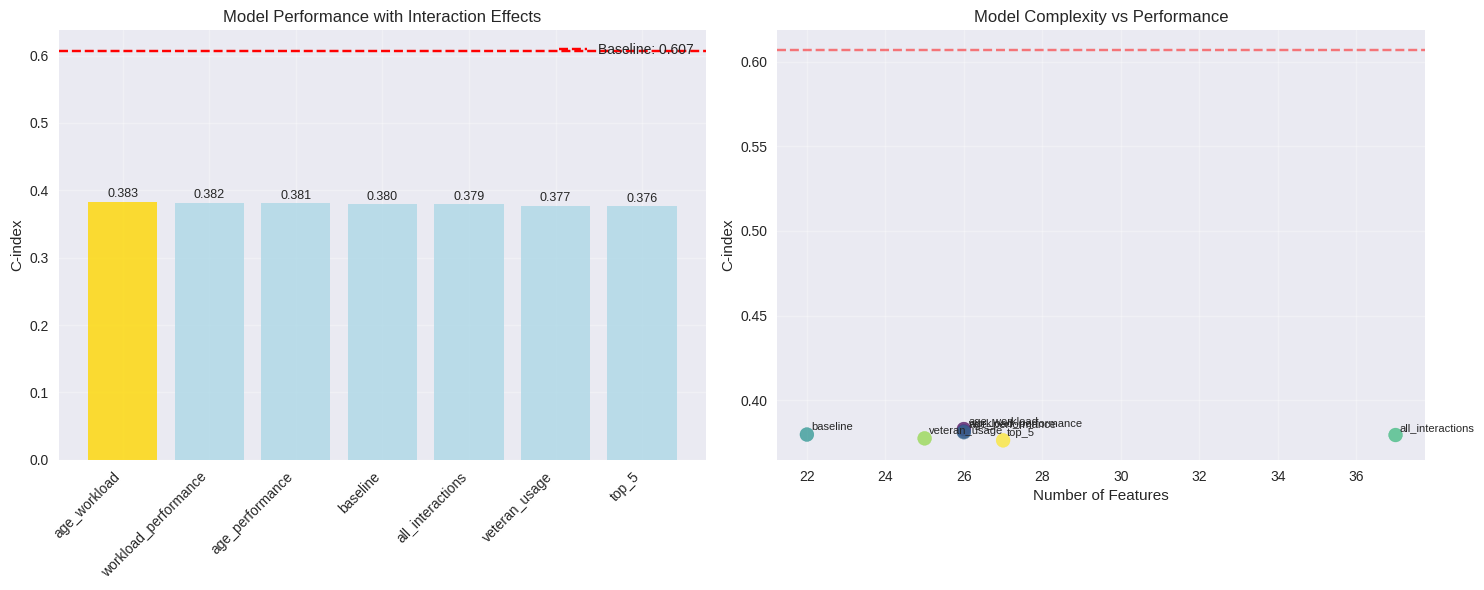

In [6]:
# Compare interaction model results
print("🎯 INTERACTION EFFECTS RESULTS")
print("=" * 35)

# Create results summary
valid_results = {k: v for k, v in results.items() if not pd.isna(v.get('c_index', np.nan))}

if valid_results:
    results_df = pd.DataFrame({
        k: {
            'c_index': v['c_index'],
            'r_hat_max': v.get('r_hat_max', np.nan),
            'divergences': v.get('divergences', np.nan),
            'n_features': v.get('n_features', 0),
            'n_interactions': v.get('n_interactions', 0)
        } for k, v in valid_results.items()
    }).T
    
    results_df = results_df.sort_values('c_index', ascending=False)
    
    print("Performance Ranking:")
    print("-" * 20)
    
    baseline_c_index = 0.607
    
    for i, (model_name, row) in enumerate(results_df.iterrows(), 1):
        c_index = row['c_index']
        improvement = c_index - baseline_c_index
        convergence = "✅" if row['r_hat_max'] < 1.05 and row['divergences'] < 100 else "⚠️"
        
        print(f"{i}. {model_name:<18}: C-index = {c_index:.3f} ({improvement:+.3f}) {convergence}")
        print(f"   Features: {row['n_features']:.0f} total ({row['n_interactions']:.0f} interactions)")
        print(f"   Convergence: R̂={row['r_hat_max']:.3f}, Div={row['divergences']:.0f}")
        print()
    
    # Find best model
    best_model = results_df.index[0]
    best_c_index = results_df.loc[best_model, 'c_index']
    improvement = best_c_index - baseline_c_index
    
    print(f"🏆 BEST MODEL: {best_model}")
    print(f"   C-index: {best_c_index:.3f}")
    print(f"   Improvement: {improvement:+.3f} over baseline")
    
    if improvement > 0.01:
        print(f"   ✅ Significant improvement with interaction effects!")
    elif improvement > 0:
        print(f"   ✅ Modest improvement with interaction effects")
    else:
        print(f"   ⚠️ No improvement - interactions may not be beneficial")
    
    # Visualize results
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # C-index comparison
    model_names = results_df.index
    c_indices = results_df['c_index']
    colors = ['gold' if name == best_model else 'lightblue' for name in model_names]
    
    bars = axes[0].bar(range(len(model_names)), c_indices, color=colors, alpha=0.8)
    axes[0].axhline(y=baseline_c_index, color='red', linestyle='--', 
                    label=f'Baseline: {baseline_c_index:.3f}')
    axes[0].set_xticks(range(len(model_names)))
    axes[0].set_xticklabels(model_names, rotation=45, ha='right')
    axes[0].set_ylabel('C-index')
    axes[0].set_title('Model Performance with Interaction Effects')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, c_idx in zip(bars, c_indices):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                     f'{c_idx:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Complexity vs Performance
    axes[1].scatter(results_df['n_features'], results_df['c_index'], 
                    s=100, alpha=0.7, c=range(len(results_df)), cmap='viridis')
    
    for name, row in results_df.iterrows():
        axes[1].annotate(name, (row['n_features'], row['c_index']), 
                         xytext=(3, 3), textcoords='offset points', fontsize=8)
    
    axes[1].axhline(y=baseline_c_index, color='red', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Number of Features')
    axes[1].set_ylabel('C-index')
    axes[1].set_title('Model Complexity vs Performance')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ No valid interaction models produced")
    print("   All models failed to converge - interactions may be too complex")

## 6. Feature Importance Analysis for Best Model

In [7]:
# Analyze feature importance for the best interaction model
if valid_results:
    print(f"🔍 FEATURE IMPORTANCE: {best_model.upper()} MODEL")
    print("=" * 50)
    
    best_result = results[best_model]
    beta_coeffs = best_result['beta_mean']
    feature_names = best_result['feature_names']
    
    # Create feature importance dataframe
    feature_importance = []
    for i, (name, coef) in enumerate(zip(feature_names, beta_coeffs)):
        is_interaction = any(x in name for x in ['_x_', 'age_', 'veteran_', 'ip_', 'games_'])
        
        feature_importance.append({
            'feature': name,
            'coefficient': coef,
            'abs_coef': abs(coef),
            'type': 'Interaction' if is_interaction else 'Main Effect',
            'direction': 'Protective' if coef > 0 else 'Risk Factor'
        })
    
    importance_df = pd.DataFrame(feature_importance).sort_values('abs_coef', ascending=False)
    
    # Show top features
    print("Top 10 Most Important Features:")
    print("-" * 35)
    for _, row in importance_df.head(10).iterrows():
        symbol = "🛡️" if row['direction'] == 'Protective' else "⚠️"
        type_symbol = "🔗" if row['type'] == 'Interaction' else "📊"
        print(f"{symbol} {type_symbol} {row['feature']:<25}: {row['coefficient']:+.3f} ({row['direction']})")
    
    # Analyze interaction vs main effects
    interaction_effects = importance_df[importance_df['type'] == 'Interaction']
    main_effects = importance_df[importance_df['type'] == 'Main Effect']
    
    print(f"\n📊 EFFECT TYPE ANALYSIS:")
    print("-" * 25)
    print(f"Main effects: {len(main_effects)} features")
    print(f"  Average |coefficient|: {main_effects['abs_coef'].mean():.3f}")
    print(f"  Top main effect: {main_effects.iloc[0]['feature']} ({main_effects.iloc[0]['coefficient']:+.3f})")
    
    print(f"\nInteraction effects: {len(interaction_effects)} features")
    if len(interaction_effects) > 0:
        print(f"  Average |coefficient|: {interaction_effects['abs_coef'].mean():.3f}")
        print(f"  Top interaction: {interaction_effects.iloc[0]['feature']} ({interaction_effects.iloc[0]['coefficient']:+.3f})")
        
        # Show top interactions by category
        print(f"\n🔗 TOP INTERACTIONS BY CATEGORY:")
        interaction_categories = {
            'Age × Workload': ['age_x_ip', 'age_x_games', 'age_x_starts', 'age_x_high_workload'],
            'Age × Performance': ['age_x_era', 'age_x_whip', 'age_x_war', 'age_x_high_era'],
            'Workload × Performance': ['ip_x_era', 'games_x_era', 'ip_x_whip', 'games_x_war'],
            'Veteran × Usage': ['veteran_x_ip', 'veteran_x_games', 'veteran_x_era']
        }
        
        for category, interaction_list in interaction_categories.items():
            category_interactions = importance_df[importance_df['feature'].isin(interaction_list)]
            if len(category_interactions) > 0:
                top_interaction = category_interactions.iloc[0]
                symbol = "🛡️" if top_interaction['direction'] == 'Protective' else "⚠️"
                print(f"  {symbol} {category:<20}: {top_interaction['feature']} ({top_interaction['coefficient']:+.3f})")
    
    print(f"\n💡 CLINICAL INTERPRETATION:")
    print("=" * 25)
    if improvement > 0.01:
        print(f"✅ Interaction effects provide meaningful improvement")
        print(f"   Combined risk factors are more predictive than individual factors")
        if len(interaction_effects) > 0:
            top_interaction = interaction_effects.iloc[0]
            print(f"   Key insight: {top_interaction['feature']} is the strongest interaction")
    else:
        print(f"⚠️ Interaction effects don't significantly improve prediction")
        print(f"   Simple main effects model may be preferred for interpretability")
    
    print(f"\n✅ INTERACTION EFFECTS ANALYSIS COMPLETE")
    print(f"   Best model: {best_model}")
    print(f"   Final C-index: {best_c_index:.3f}")
    print(f"   Improvement: {improvement:+.3f}")

else:
    print("❌ Cannot analyze feature importance - no valid models")

🔍 FEATURE IMPORTANCE: AGE_WORKLOAD MODEL
Top 10 Most Important Features:
-----------------------------------
⚠️ 🔗 age_x_starts             : -0.090 (Risk Factor)
⚠️ 🔗 age_prev                 : -0.034 (Risk Factor)
🛡️ 📊 g_prev                   : +0.033 (Protective)
🛡️ 🔗 age_x_games              : +0.032 (Protective)
🛡️ 📊 l_prev                   : +0.022 (Protective)
🛡️ 📊 so_prev                  : +0.021 (Protective)
🛡️ 📊 er_prev                  : +0.018 (Protective)
🛡️ 🔗 whip_prev                : +0.017 (Protective)
⚠️ 🔗 age_x_ip                 : -0.015 (Risk Factor)
🛡️ 🔗 veteran_prev             : +0.013 (Protective)

📊 EFFECT TYPE ANALYSIS:
-------------------------
Main effects: 17 features
  Average |coefficient|: 0.009
  Top main effect: g_prev (+0.033)

Interaction effects: 9 features
  Average |coefficient|: 0.024
  Top interaction: age_x_starts (-0.090)

🔗 TOP INTERACTIONS BY CATEGORY:
  ⚠️ Age × Workload      : age_x_starts (-0.090)

💡 CLINICAL INTERPRETATION:
⚠️ Interac